In [147]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats

sns.set_palette('muted') 
sns.set_color_codes('muted')
sns.set_style('white') 

import warnings
warnings.filterwarnings('ignore')

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
!pip install xgboost

In [350]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import IsolationForest

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor, plot_tree

from sklearn_pandas import DataFrameMapper
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import PredictionErrorDisplay

from sklearn.decomposition import PCA

from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

from tqdm import tqdm

import xgboost as xgb

In [467]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('Y_train.csv')
test_data = pd.read_csv('X_test.csv')

# 0. Базовая модель

In [468]:
# Creating baseline model which predicts 6.5 always
class BaselineModel:
    def __init__(self, constant):
        self.constant = constant
        
    def predict(self, X):
        return np.full(X.shape[0], self.constant)
baseline = BaselineModel(6.5)
y_pred = baseline.predict(X_train)
print (f'LR MAPE test = ', mean_absolute_percentage_error(y_true=y_train, y_pred=y_pred))

LR MAPE test =  0.004239109764264365


# 1. Базовый препроцессинг (Basic preprocessing)

## 1.1. Датасет (Dataset)

In [469]:
train_data = pd.concat([X_train, y_train], axis=1)

### `train_data`

In [188]:
train_data.sample(3)

,Time (h),Aeration rate(Fg:L/h),Agitator RPM(RPM:RPM),Sugar feed rate(Fs:L/h),Acid flow rate(Fa:L/h),Base flow rate(Fb:L/h),Heating/cooling water flow rate(Fc:L/h),Heating water flow rate(Fh:L/h),Water for injection/dilution(Fw:L/h),Air head pressure(pressure:bar),...,Offline Penicillin concentration(P_offline:P(g L^{-1})),Offline Biomass concentratio(X_offline:X(g L^{-1})),Carbon evolution rate(CER:g/h),Ammonia shots(NH3_shots:kgs),Viscosity(Viscosity_offline:centPoise),Fault reference(Fault_ref:Fault ref),1- No Raman spec,1-Raman spec recorded,2-PAT control(PAT_ref:PAT ref),pH(pH:pH)
5600,156.2,75,100,90,0.0,38.207,8.445600,79.2650,0,0.9,...,NaN,NaN,1.65360,0,NaN,0,1,5,5,6.4871
3549,254.0,60,100,80,0.0,0.000,65.087000,1.6686,0,0.9,...,NaN,NaN,0.90168,0,NaN,0,1,3,3,6.5040
3161,176.4,75,100,80,0.0,89.892,0.061406,71.8500,150,0.9,...,NaN,NaN,1.53130,0,NaN,0,1,3,3,6.5413


In [189]:
print(train_data.ndim)
print(train_data.shape)
print(train_data.size)

2
(10863, 35)
380205


In [190]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10863 entries, 0 to 10862
Data columns (total 35 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   Time (h)                                                 10863 non-null  float64
 1   Aeration rate(Fg:L/h)                                    10863 non-null  int64  
 2   Agitator RPM(RPM:RPM)                                    10863 non-null  int64  
 3   Sugar feed rate(Fs:L/h)                                  10863 non-null  int64  
 4   Acid flow rate(Fa:L/h)                                   10863 non-null  float64
 5   Base flow rate(Fb:L/h)                                   10863 non-null  float64
 6   Heating/cooling water flow rate(Fc:L/h)                  10863 non-null  float64
 7   Heating water flow rate(Fh:L/h)                          10863 non-null  float64
 8   Water for injection/diluti

### `test_data`

In [191]:
test_data.sample(3)

,Time (h),Aeration rate(Fg:L/h),Agitator RPM(RPM:RPM),Sugar feed rate(Fs:L/h),Acid flow rate(Fa:L/h),Base flow rate(Fb:L/h),Heating/cooling water flow rate(Fc:L/h),Heating water flow rate(Fh:L/h),Water for injection/dilution(Fw:L/h),Air head pressure(pressure:bar),...,Oxygen in percent in off-gas(O2:O2 (%)),Offline Penicillin concentration(P_offline:P(g L^{-1})),Offline Biomass concentratio(X_offline:X(g L^{-1})),Carbon evolution rate(CER:g/h),Ammonia shots(NH3_shots:kgs),Viscosity(Viscosity_offline:centPoise),Fault reference(Fault_ref:Fault ref),1- No Raman spec,1-Raman spec recorded,2-PAT control(PAT_ref:PAT ref)
1572,170.2,75,100,80,0.0,63.1010,100.7700,14.810,150,0.9,...,0.19122,NaN,NaN,1.6589,0,NaN,0,1,11,11
253,136.4,75,100,90,0.0,66.2050,2.4995,21.212,100,1.0,...,0.18653,NaN,NaN,1.7656,0,NaN,0,1,10,10
648,215.4,65,100,80,0.0,4.4297,20.5000,166.790,250,0.9,...,0.19643,NaN,NaN,1.1534,0,NaN,0,1,10,10


In [192]:
print(test_data.ndim)
print(test_data.shape)
print(test_data.size)

2
(1917, 34)
65178


In [193]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1917 entries, 0 to 1916
Data columns (total 34 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   Time (h)                                                 1917 non-null   float64
 1   Aeration rate(Fg:L/h)                                    1917 non-null   int64  
 2   Agitator RPM(RPM:RPM)                                    1917 non-null   int64  
 3   Sugar feed rate(Fs:L/h)                                  1917 non-null   int64  
 4   Acid flow rate(Fa:L/h)                                   1917 non-null   float64
 5   Base flow rate(Fb:L/h)                                   1917 non-null   float64
 6   Heating/cooling water flow rate(Fc:L/h)                  1917 non-null   float64
 7   Heating water flow rate(Fh:L/h)                          1917 non-null   float64
 8   Water for injection/dilution

## 1.2. Отсутствующие значения (Missing values)

In [470]:
# percentage of missing data
(train_data.isna().sum() / len(train_data)).rename('percent of NA').to_frame().style.bar(vmax=1, vmin=0).format('{:.2%}')

,percent of NA
Time (h),0.00%
Aeration rate(Fg:L/h),0.00%
Agitator RPM(RPM:RPM),0.00%
Sugar feed rate(Fs:L/h),0.00%
Acid flow rate(Fa:L/h),0.00%
Base flow rate(Fb:L/h),0.00%
Heating/cooling water flow rate(Fc:L/h),0.00%
Heating water flow rate(Fh:L/h),0.00%
Water for injection/dilution(Fw:L/h),0.00%
Air head pressure(pressure:bar),0.00%


In [471]:
train_data=train_data.drop(columns = ['PAA concentration offline(PAA_offline:PAA (g L^{-1}))',
                                'NH_3 concentration off-line(NH3_offline:NH3 (g L^{-1}))',
                                'Offline Penicillin concentration(P_offline:P(g L^{-1}))',
                                'Offline Biomass concentratio(X_offline:X(g L^{-1}))',
                                'Viscosity(Viscosity_offline:centPoise)'])

In [472]:
test_data=test_data.drop(columns = ['PAA concentration offline(PAA_offline:PAA (g L^{-1}))',
                                'NH_3 concentration off-line(NH3_offline:NH3 (g L^{-1}))',
                                'Offline Penicillin concentration(P_offline:P(g L^{-1}))',
                                'Offline Biomass concentratio(X_offline:X(g L^{-1}))',
                                'Viscosity(Viscosity_offline:centPoise)'])

## 1.3. Выбросы

In [473]:
features = train_data.columns[:-1]

In [474]:
iqr=scipy.stats.iqr(train_data[features], axis = 0)
q1=np.quantile(train_data[features], .25, axis=0)
q3=np.quantile(train_data[features], .75, axis=0)

In [475]:
# boundaries for outliers deleting
boundaries=[]
boundaries.append([*(q1-iqr)])
boundaries.append([*(q3+iqr)])
outliers_remedy=pd.DataFrame(boundaries, columns=features)
outliers_remedy

,Time (h),Aeration rate(Fg:L/h),Agitator RPM(RPM:RPM),Sugar feed rate(Fs:L/h),Acid flow rate(Fa:L/h),Base flow rate(Fb:L/h),Heating/cooling water flow rate(Fc:L/h),Heating water flow rate(Fh:L/h),Water for injection/dilution(Fw:L/h),Air head pressure(pressure:bar),...,PAA flow(Fpaa:PAA flow (L/h)),Oil flow(Foil:L/hr),Oxygen Uptake Rate(OUR:(g min^{-1})),Oxygen in percent in off-gas(O2:O2 (%)),Carbon evolution rate(CER:g/h),Ammonia shots(NH3_shots:kgs),Fault reference(Fault_ref:Fault ref),1- No Raman spec,1-Raman spec recorded,2-PAT control(PAT_ref:PAT ref)
0,-62.8,45.0,100.0,60.0,0.0,-15.2265,-68.381,-11.4263,-250.0,0.7,...,-2.0,15.0,0.29737,0.18299,0.20698,0.0,0.0,1.0,-2.0,-2.0
1,288.8,90.0,100.0,105.0,0.0,126.8955,174.169,22.8529,500.0,1.3,...,16.0,39.0,2.33149,0.19919,2.34136,0.0,0.0,1.0,13.0,13.0


In [476]:
# удаление строк с выбросами
for column in train_data[features].columns:
    train_data=train_data[(train_data[column] >= outliers_remedy[column][0]) & (train_data[column] <= outliers_remedy[column][1])]

In [477]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4148 entries, 240 to 10810
Data columns (total 30 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Time (h)                                        4148 non-null   float64
 1   Aeration rate(Fg:L/h)                           4148 non-null   int64  
 2   Agitator RPM(RPM:RPM)                           4148 non-null   int64  
 3   Sugar feed rate(Fs:L/h)                         4148 non-null   int64  
 4   Acid flow rate(Fa:L/h)                          4148 non-null   float64
 5   Base flow rate(Fb:L/h)                          4148 non-null   float64
 6   Heating/cooling water flow rate(Fc:L/h)         4148 non-null   float64
 7   Heating water flow rate(Fh:L/h)                 4148 non-null   float64
 8   Water for injection/dilution(Fw:L/h)            4148 non-null   int64  
 9   Air head pressure(pressure:bar)       

## 1.4. Корреляция

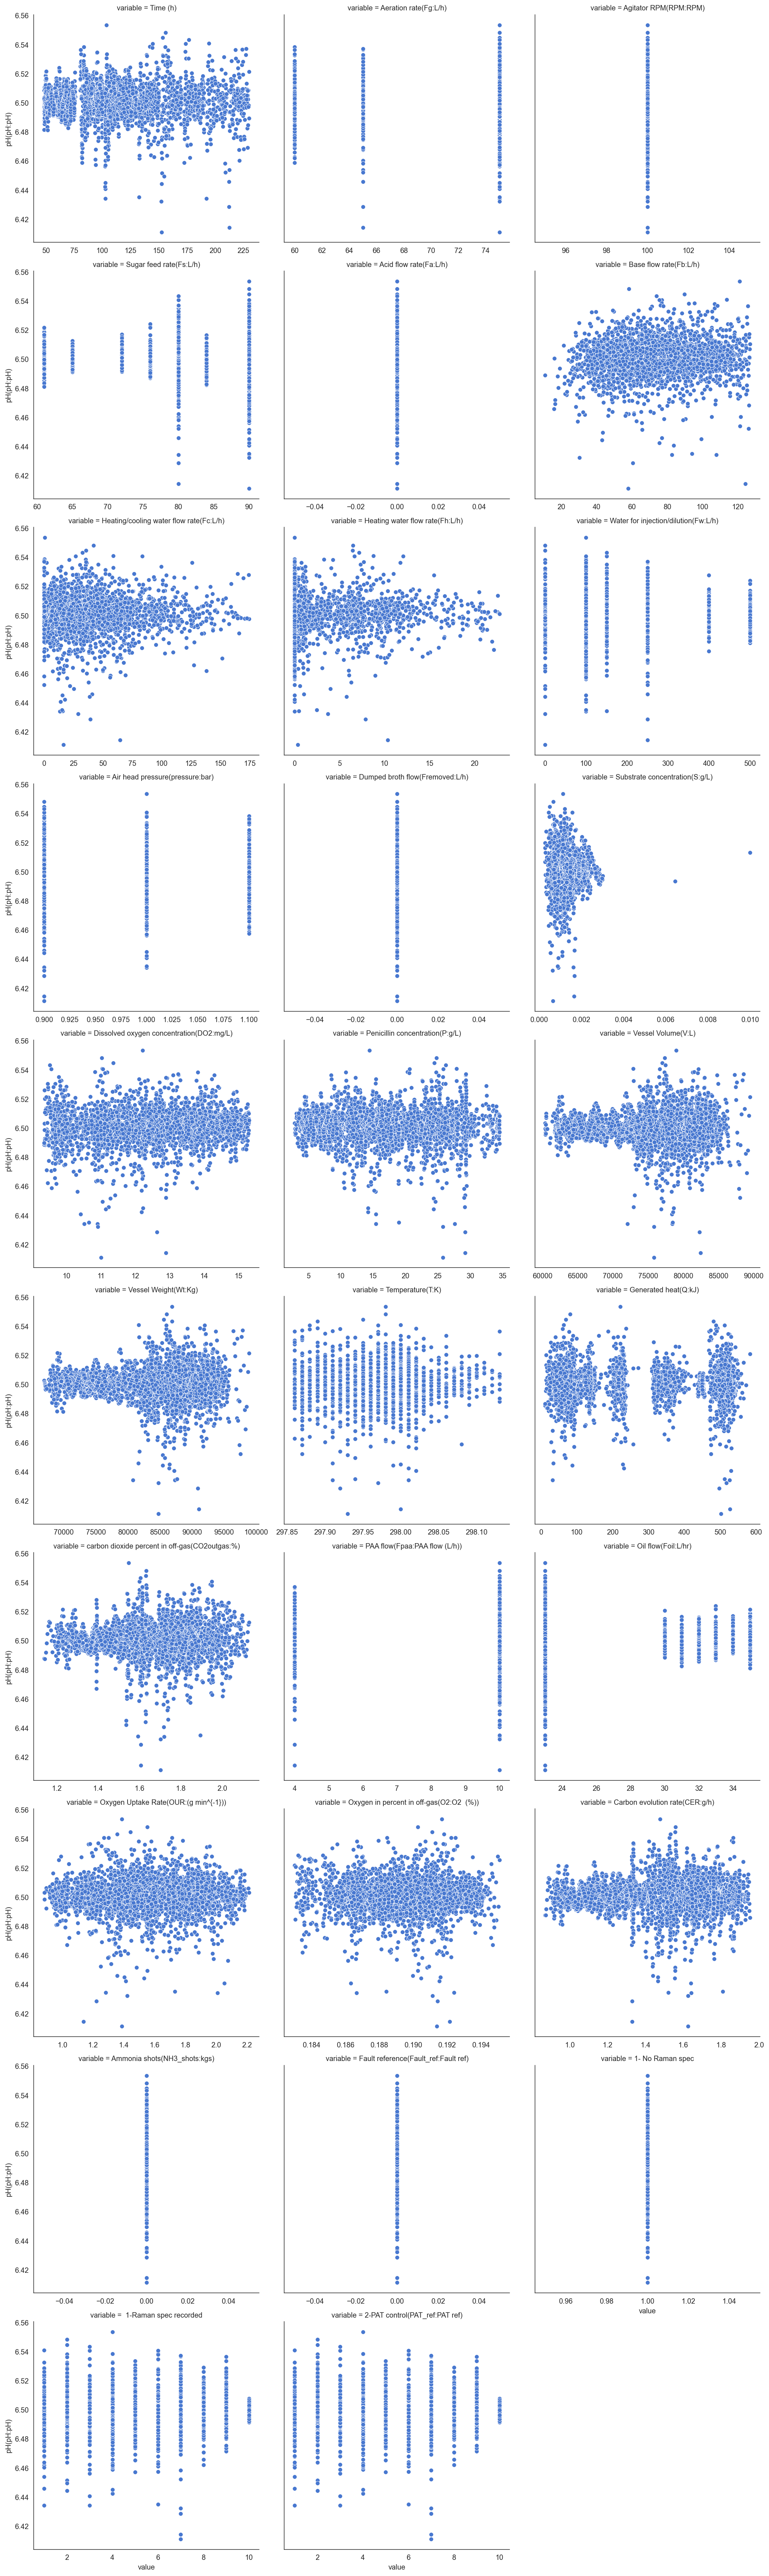

In [374]:
sns.relplot(data=train_data.melt(id_vars=['pH(pH:pH)']),
            x='value', y='pH(pH:pH)', col='variable', col_wrap=3, 
            facet_kws=dict(sharex=False)
           )

Некоторые значения постоянные - константы и не влияют на таргет.

In [478]:
# удаление
train_data=train_data.drop(columns = ['Agitator RPM(RPM:RPM)', 
                                'Ammonia shots(NH3_shots:kgs)', 
                                'Fault reference(Fault_ref:Fault ref)', 
                                '1- No Raman spec'])
test_data=test_data.drop(columns = ['Agitator RPM(RPM:RPM)', 
                                    'Ammonia shots(NH3_shots:kgs)', 
                                    'Fault reference(Fault_ref:Fault ref)', 
                                    '1- No Raman spec'])

# 2. Разделение `X_train` и `y_train` на тренировочную выборку и тестовую выборку (Train & Test Samples Splitting)

In [479]:
X, y = train_data[train_data.columns[:-1]], train_data[train_data.columns[-1]]

In [480]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                    random_state = 4, shuffle=False)

# 3. ML Модель `Mapper` & `Pipeline` & `GridSearch` & `RandomSearch`

Так как у нас много признаком, можно провести `PCA` - метод главных компонентов для уменьшения размерности.

## 3.1. PCA

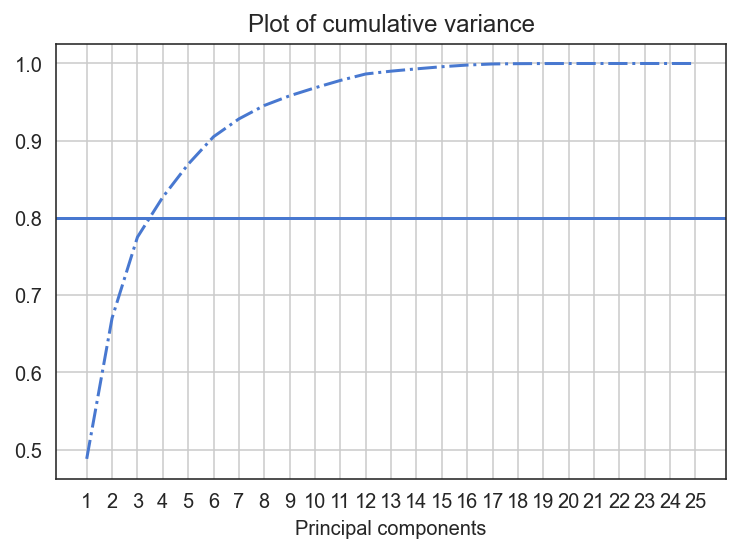

In [378]:
# посмотрим, какое количество гланых компонент использовать в пайплайне

X_train_scaled = MinMaxScaler().fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled)

# к новому датасету создадим названия признаков
X_train_scaled.columns = X_train.columns.values
X_train_scaled.index = X_train.index

def var_plot(x, label, h=0):
    plt.plot(range(len(x)), x, linestyle="-.")
    plt.title('Plot of '+ label + ' variance')
    plt.xticks(range(len(x)), [y+1 for y in range(len(x))])
    plt.xlabel('Principal components')
    plt.axhline(h)
    plt.grid()
    plt.show()

pca = PCA(n_components=None).fit(X_train_scaled)

# кумулятивная дисерсия, трешхолд = 80%
cumulVarExplained = np.cumsum(pca.explained_variance_ratio_)
cumulVarExplained

var_plot(cumulVarExplained, "cumulative", h=0.8)

**Вывод:** необходимо взять 2 компонентa, так как кумулятивно они объясняют большую часть дисперсии - после 3 `PC` увеличение объяснения дисперсии меньше.

## 3.2. Mодель и Пайплайн

In [481]:
mapper = DataFrameMapper([([feature], SimpleImputer()) for feature in X_train.columns.tolist()]) #+\
                        
                         
                         #([feature], IsolationForest()) for feature in X_train.columns.tolist())
                         #[([feature], OneHotEncoder(handle_unknown = 'ignore')) for feature in nominal_features],
                             #df_out=True)

                    
#preprocessor = ColumnTransformer(transformers=[('simpleimputer', SimpleImputer()),
                                               #('num', StandardScaler())])
                                               #('outlier', IsolationForest(contamination=0.05))])
                    
pipeline = Pipeline(steps = [('preprocessing', mapper), 
                             ('scaler', MinMaxScaler()),
                             ('pca', PCA(n_components=2)),
                             #('xgb', xgb.XGBRegressor(objective="reg:linear", random_state=42,
                                        #              n_estimators = 500, eta = 0.4, max_depth = 6))])
        
                             ('lr', LinearRegression())])
                             #('rf', RandomForestRegressor())])
                             #('dtr', DecisionTreeRegressor(random_state=41))])

    
pipeline

Pipeline(steps=[('preprocessing',
                 DataFrameMapper(drop_cols=[],
                                 features=[(['Time (h)'], SimpleImputer()),
                                           (['Aeration rate(Fg:L/h)'],
                                            SimpleImputer()),
                                           (['Sugar feed rate(Fs:L/h)'],
                                            SimpleImputer()),
                                           (['Acid flow rate(Fa:L/h)'],
                                            SimpleImputer()),
                                           (['Base flow rate(Fb:L/h)'],
                                            SimpleImputer()),
                                           (['Heating/cooling water flow '
                                             'rate(Fc:L/h)'],
                                            SimpleImputer()),
                                           (['Heating wate...
                                            SimpleImputer()),
                                           (['Oxygen Uptake Rate(OUR:(g '
                                             'min^{-1}))'],
                                            SimpleImputer()),
                                           (['Oxygen in percent in '
                                             'off-gas(O2:O2  (%))'],
                                            SimpleImputer()),
                                           (['Carbon evolution rate(CER:g/h)'],
                                            SimpleImputer()),
                                           ([' 1-Raman spec recorded'],
                                            SimpleImputer()),
                                           (['2-PAT control(PAT_ref:PAT ref)'],
                                            SimpleImputer())])),
                ('scaler', MinMaxScaler()), ('pca', PCA(n_components=2)),
                ('lr', LinearRegression())])

Подберем оптимальные параметры для модели:

In [409]:
%%time
params_grid = dict(n_estimators = [400, 500, 600], eta = [0.3, 0.4, 0.5], max_depth = [5, 6, 7])

results = []

for params in tqdm(ParameterGrid(params_grid)):
    
    pipeline = Pipeline(steps = [('preprocessing', mapper), 
                                 ('scaler', MinMaxScaler()),
                                 ('pca', PCA(n_components=2)),
                                 ('xgb', xgb.XGBRegressor(objective="reg:linear", random_state=42,
                                                          n_estimators = params['n_estimators'],
                                                          eta = params['eta'],
                                                          max_depth = params['max_depth']))])

    
    
    pipeline.fit(X_train, y_train)
    
    pipe_preds_train = pipeline.predict(X_train)
    pipe_preds_test = pipeline.predict(X_test)
    
    results.append(dict(
        
        params=params,
        
        train_rmse = mean_squared_error(y_true=y_train, y_pred = pipe_preds_train, squared=False),
        test_rmse = mean_squared_error(y_true=y_test, y_pred = pipe_preds_test, squared=False),
        
        train_mape = mean_absolute_percentage_error(y_true=y_train, y_pred=pipe_preds_train),
        test_mape = mean_absolute_percentage_error(y_true=y_test, y_pred=pipe_preds_test)
        
    ))
results


  0%|                                                    | 0/27 [00:00<?, ?it/s]

[21:29:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


  4%|█▋                                          | 1/27 [00:00<00:17,  1.50it/s]

[21:29:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


  7%|███▎                                        | 2/27 [00:01<00:15,  1.59it/s]

[21:29:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


 11%|████▉                                       | 3/27 [00:01<00:15,  1.55it/s]

[21:29:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


 15%|██████▌                                     | 4/27 [00:02<00:13,  1.69it/s]

[21:29:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


 19%|████████▏                                   | 5/27 [00:03<00:13,  1.64it/s]

[21:29:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


 19%|████████▏                                   | 5/27 [00:03<00:15,  1.40it/s]


KeyboardInterrupt: 

In [355]:
results = pd.DataFrame(results)
results.sort_values('test_mape', ascending=False).style.bar(vmin=0, vmax=1)

,params,train_rmse,test_rmse,train_mape,test_mape
13,"{'eta': 0.4, 'max_depth': 6, 'n_estimators': 500}",0.002883,0.013341,0.000317,0.001490
14,"{'eta': 0.4, 'max_depth': 6, 'n_estimators': 600}",0.002883,0.013341,0.000317,0.001490
12,"{'eta': 0.4, 'max_depth': 6, 'n_estimators': 400}",0.002883,0.013341,0.000317,0.001490
9,"{'eta': 0.4, 'max_depth': 5, 'n_estimators': 400}",0.002978,0.013167,0.000327,0.001478
11,"{'eta': 0.4, 'max_depth': 5, 'n_estimators': 600}",0.002978,0.013167,0.000327,0.001478
10,"{'eta': 0.4, 'max_depth': 5, 'n_estimators': 500}",0.002978,0.013167,0.000327,0.001478
18,"{'eta': 0.5, 'max_depth': 5, 'n_estimators': 400}",0.002899,0.013094,0.000323,0.001458
19,"{'eta': 0.5, 'max_depth': 5, 'n_estimators': 500}",0.002899,0.013094,0.000323,0.001458
20,"{'eta': 0.5, 'max_depth': 5, 'n_estimators': 600}",0.002899,0.013094,0.000323,0.001458
21,"{'eta': 0.5, 'max_depth': 6, 'n_estimators': 400}",0.002690,0.013250,0.000294,0.001458


**Вывод:** оптимальные параметры - `{'eta': 0.4, 'max_depth': 6, 'n_estimators': 500}` - вставим их в модель.

## `.fit` of the optimal model

In [482]:
%%time
pipeline.fit(X_train, y_train)

CPU times: user 93.3 ms, sys: 17.9 ms, total: 111 ms
Wall time: 108 ms


Pipeline(steps=[('preprocessing',
                 DataFrameMapper(drop_cols=[],
                                 features=[(['Time (h)'], SimpleImputer()),
                                           (['Aeration rate(Fg:L/h)'],
                                            SimpleImputer()),
                                           (['Sugar feed rate(Fs:L/h)'],
                                            SimpleImputer()),
                                           (['Acid flow rate(Fa:L/h)'],
                                            SimpleImputer()),
                                           (['Base flow rate(Fb:L/h)'],
                                            SimpleImputer()),
                                           (['Heating/cooling water flow '
                                             'rate(Fc:L/h)'],
                                            SimpleImputer()),
                                           (['Heating wate...
                                            SimpleImputer()),
                                           (['Oxygen Uptake Rate(OUR:(g '
                                             'min^{-1}))'],
                                            SimpleImputer()),
                                           (['Oxygen in percent in '
                                             'off-gas(O2:O2  (%))'],
                                            SimpleImputer()),
                                           (['Carbon evolution rate(CER:g/h)'],
                                            SimpleImputer()),
                                           ([' 1-Raman spec recorded'],
                                            SimpleImputer()),
                                           (['2-PAT control(PAT_ref:PAT ref)'],
                                            SimpleImputer())])),
                ('scaler', MinMaxScaler()), ('pca', PCA(n_components=2)),
                ('lr', LinearRegression())])

# 4. Оценки модели (Evaluation of the model)

## 4.1. Оценка модели на Traina выборке. Evaluation on the Train Sample

In [483]:
lr_train_pred = pipeline.predict(X_train)
lr_rmse = mean_squared_error(y_true=y_train, y_pred = lr_train_pred, squared=False)
lr_mape = mean_absolute_percentage_error(y_true=y_train, y_pred=lr_train_pred)

print (f'LR RMSE train = {round(lr_rmse, 3)}')
print (f'LR MAPE train = {lr_mape}')
print (f'LR SCORE = {round(pipeline.score(X_train, y_train), 3)}')

LR RMSE train = 0.011
LR MAPE train = 0.001174220490046415
LR SCORE = 0.0


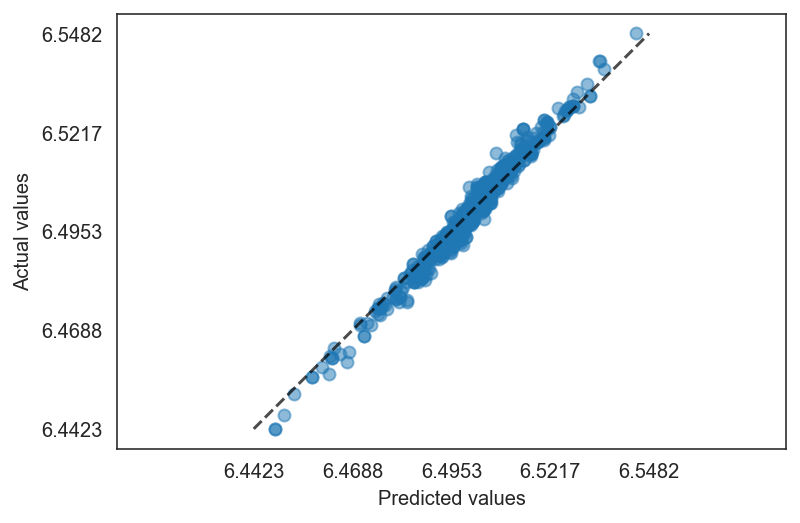

In [384]:
PredictionErrorDisplay.from_predictions(
    y_train,
    lr_train_pred,
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
)
plt.show()

## 4.2. Оценка на Тестовой Выборке. Evaluation on the Test Sample

In [484]:
lr_test_pred = pipeline.predict(X_test)
lr_rmse = mean_squared_error(y_true=y_test, y_pred = lr_test_pred, squared=False)
lr_mape = mean_absolute_percentage_error(y_true=y_test, y_pred=lr_test_pred)

print (f'LR RMSE test = {round(lr_rmse, 3)}')
print (f'LR MAPE test = {lr_mape}')
print (f'LR SCORE = {round(pipeline.score(X_test, y_test), 3)}')

LR RMSE test = 0.01
LR MAPE test = 0.0010798442518755796
LR SCORE = 0.0


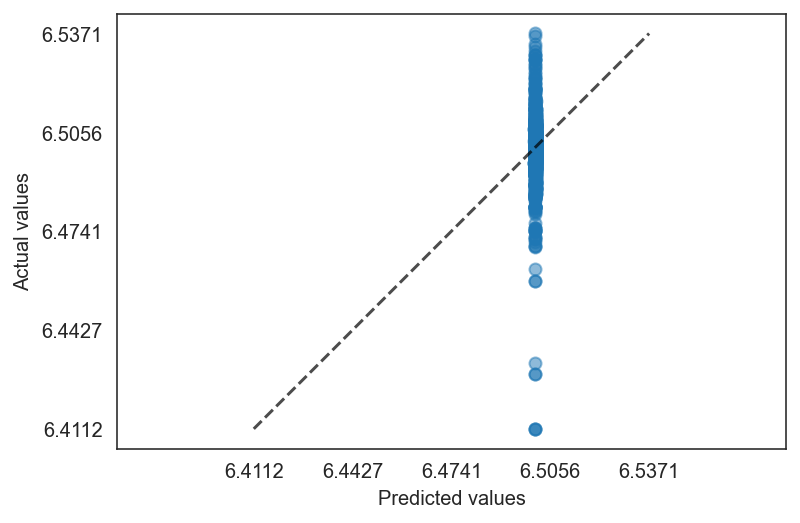

In [485]:
PredictionErrorDisplay.from_predictions(
    y_test,
    lr_test_pred,
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
)
plt.show()

**Вывод:** мы опередели базовую модель по метрике `MAPE` - также можно попробовать другие модели (укзааны в комментариях).

## 4.3. Evaluation on the Whole Sample

Выучим модель на всей выборке - оригинальный файл `X_train` и `y_train` или `train_data`.

In [486]:
%%time
pipeline.fit(X, y)

CPU times: user 100 ms, sys: 8.41 ms, total: 108 ms
Wall time: 141 ms


Pipeline(steps=[('preprocessing',
                 DataFrameMapper(drop_cols=[],
                                 features=[(['Time (h)'], SimpleImputer()),
                                           (['Aeration rate(Fg:L/h)'],
                                            SimpleImputer()),
                                           (['Sugar feed rate(Fs:L/h)'],
                                            SimpleImputer()),
                                           (['Acid flow rate(Fa:L/h)'],
                                            SimpleImputer()),
                                           (['Base flow rate(Fb:L/h)'],
                                            SimpleImputer()),
                                           (['Heating/cooling water flow '
                                             'rate(Fc:L/h)'],
                                            SimpleImputer()),
                                           (['Heating wate...
                                            SimpleImputer()),
                                           (['Oxygen Uptake Rate(OUR:(g '
                                             'min^{-1}))'],
                                            SimpleImputer()),
                                           (['Oxygen in percent in '
                                             'off-gas(O2:O2  (%))'],
                                            SimpleImputer()),
                                           (['Carbon evolution rate(CER:g/h)'],
                                            SimpleImputer()),
                                           ([' 1-Raman spec recorded'],
                                            SimpleImputer()),
                                           (['2-PAT control(PAT_ref:PAT ref)'],
                                            SimpleImputer())])),
                ('scaler', MinMaxScaler()), ('pca', PCA(n_components=2)),
                ('lr', LinearRegression())])

In [487]:
predictions = pipeline.predict(test_data)

In [488]:
predictions

array([6.50128455, 6.5012835 , 6.50128191, ..., 6.50081723, 6.50081611,
       6.50081333])

In [489]:
y_train

240     6.4877
241     6.4875
242     6.4919
243     6.4983
244     6.5048
         ...  
7330    6.4996
7331    6.4993
7332    6.5011
7333    6.5020
7334    6.5021
Name: pH(pH:pH), Length: 2903, dtype: float64

In [492]:
submission = pd.DataFrame(data = predictions, index = test_data.index)\
.rename(columns={0: "pH(pH:pH)"}).set_index('pH(pH:pH)')
submission

""
pH(pH:pH)
6.501285
6.501283
6.501282
6.501282
6.501281
...
6.500813
6.500815
6.500817


In [493]:
submission.to_csv('submission.csv')